<a href="https://colab.research.google.com/github/heyychandan/stockmp/blob/main/LSTMStockMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install yfinance tensorflow pandas numpy matplotlib scikit-learn

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Configuration ---
TICKER = 'AAPL'  # Apple Inc.
START_DATE = '2015-01-01'
END_DATE = '2024-01-01'
TEST_DATA_SIZE = 60 # Number of days to use for testing

# 1. Fetch Data
print(f"Fetching data for {TICKER}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Use only the 'Close' price for prediction
data_close = data['Close'].values.reshape(-1, 1)

print("Data fetched successfully. Head of data:")
print(data.head())

Fetching data for AAPL...


/tmp/ipython-input-2076158491.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Data fetched successfully. Head of data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.237551  24.705320  23.798600  24.694235  212818400
2015-01-05  23.554741  24.086801  23.368521  24.006992  257142000
2015-01-06  23.556961  23.816340  23.195602  23.619034  263188400
2015-01-07  23.887278  23.987038  23.654501  23.765347  160423600
2015-01-08  24.805082  24.862723  24.097885  24.215383  237458000


In [9]:
# 2. Scale the Data (Normalization)
# Scales values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

# 3. Create Training Data
training_data_len = len(scaled_data) - TEST_DATA_SIZE
train_data = scaled_data[0:training_data_len, :]

# Lookback period: The LSTM model will use the price from the previous X days to predict the next day.
TIME_STEP = 60 # Use the last 60 days of data

X_train = []
y_train = []

for i in range(TIME_STEP, training_data_len):
    # X_train gets the last 60 days (0 to 59, 1 to 60, etc.)
    X_train.append(train_data[i-TIME_STEP:i, 0])
    # y_train gets the 61st day (the target value)
    y_train.append(train_data[i, 0])

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for the LSTM model (TensorFlow expects 3D: [samples, time steps, features])
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"\nTraining data shape: {X_train.shape}")


Training data shape: (2144, 60, 1)


In [10]:
# 4. Build the LSTM Model
model = Sequential()

# Add the first LSTM layer with return_sequences=True to pass data to the next LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add a second LSTM layer
model.add(LSTM(50, return_sequences=False))

# Add a Dense layer (regular neural network layer) for the final output
model.add(Dense(25))
model.add(Dense(1)) # Output layer gives one value: the predicted price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Train the Model
# epochs: number of times the model sees the entire dataset
# batch_size: number of samples per gradient update
print("\nStarting model training...")
model.fit(X_train, y_train, batch_size=1, epochs=1)
print("Model trained successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting model training...
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - loss: 0.0050
Model trained successfully.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


/tmp/ipython-input-1402927946.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # Add predictions to the validation set


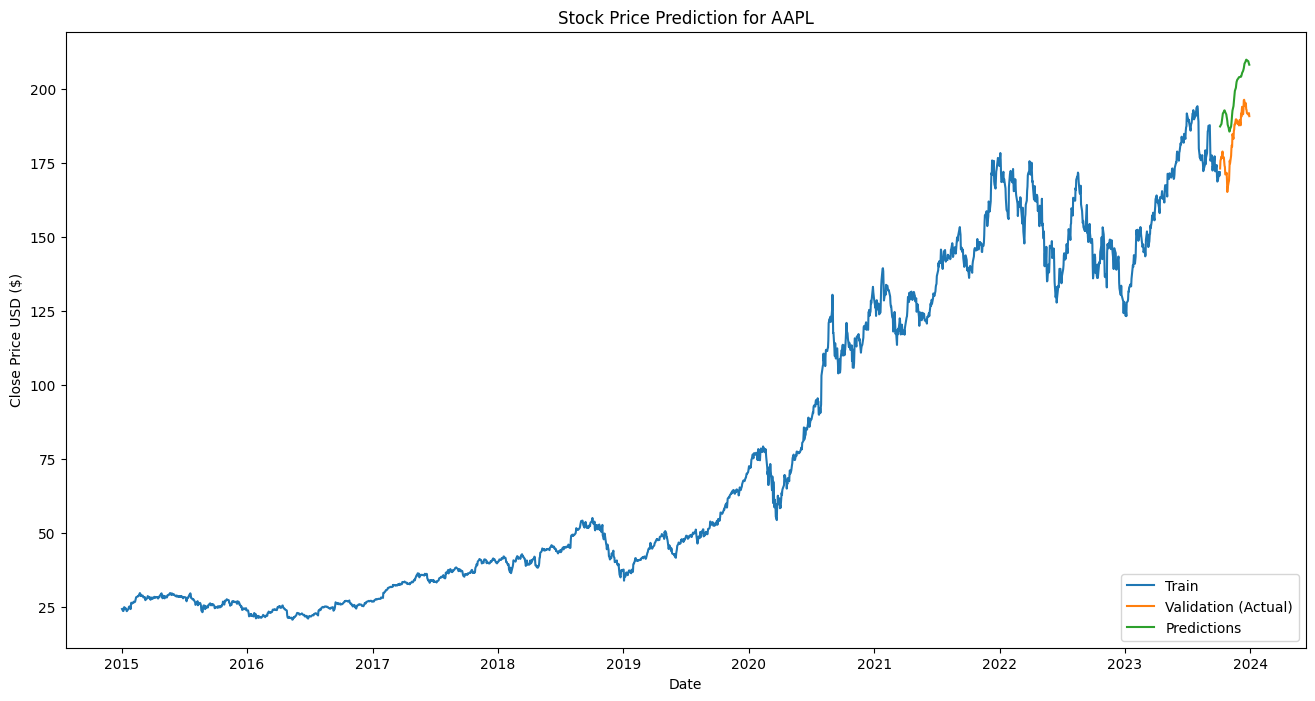


Root Mean Squared Error (RMSE): 14.36


In [11]:
# 6. Create Test Data Set
test_data = scaled_data[training_data_len - TIME_STEP:, :]

X_test = []
y_test = data_close[training_data_len:, :] # Actual unscaled closing prices

for i in range(TIME_STEP, len(test_data)):
    X_test.append(test_data[i-TIME_STEP:i, 0])

# Convert to NumPy array and reshape for LSTM
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 7. Make Predictions
predictions = model.predict(X_test)

# Inverse transform the predictions (get them back to actual dollar amounts)
predictions = scaler.inverse_transform(predictions)

# 8. Visualize the Results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions # Add predictions to the validation set

plt.figure(figsize=(16, 8))
plt.title(f'Stock Price Prediction for {TICKER}')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plot training data
plt.plot(train['Close'])

# Plot actual vs. predicted prices for the validation set
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Validation (Actual)', 'Predictions'], loc='lower right')
plt.show()

# Print metrics (optional but good for a resume)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")